# Inital set up

In [1]:
require(readr)
require(tidyverse)
require(dplyr)
require(caret)
require(edgeR)
require(ggplot2)
require(pROC)
require(reshape2)
require(pROC)
require(readxl)
require(VennDiagram)
require(sva)
require(cluster)
require(ggpubr)

source('/storeData/home/xucongmin/R_functions_bulkRNA.R')

Loading required package: readr

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ purrr     1.0.2
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: caret

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loading required package: edgeR

Loading required package: limma

Loading required package: pROC

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required pa

# Loading data and initial normalization

In [21]:
data_file = "/storeData/project/19-preRD_isomir_CRC/code_figures/10_new_analysis_output/merge_isomiR/merge_isomiR_833_ReadsCount.tsv" # the up-to-date output from Xinjie
raw_data <- readr::read_tsv(data_file)
raw_data = as.data.frame(raw_data)
rownames(raw_data) = raw_data$isomiRs  
raw_data = raw_data[, -1]
#colnames(raw_data) =  gsub("R03|\\.isomiRs-detection", "", colnames(raw_data))

colnames(raw_data) =  gsub("R03", "", colnames(raw_data))
colnames(raw_data) =  sub("-.*", "", colnames(raw_data))

# keep only those features with more than 5 reads in at least 10 samples, to reduce computation burdon
keep = rowSums(raw_data > 5) >= 10
cpm = calculate_cpm(raw_data)
irp = calculate_cpf(raw_data)

raw_data = raw_data[keep,]
cpm = cpm[keep,]
irp = cpf[keep,]

saveRDS(raw_data, '/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/raw_data.rds')
saveRDS(cpm, '/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/cpm.rds')
saveRDS(irp, '/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/irp.rds')


Rows: 649574 Columns: 834
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr   (1): isomiRs
dbl (833): R03P2107060012, R03P2107060015, R03P2107060041, R03P2107060042, R...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
raw_data = readRDS('/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/raw_data.rds')
cpm = readRDS('/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/cpm.rds')
irp = readRDS('/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/irp.rds')


# Handling clinical information

In [15]:
table(sample_info$year)


2022 2023 
 406  427 

In [13]:
sample_info <- read.csv("/storeData/project/19-preRD_isomir_CRC/code_figures/CRC_clinical_lastSheet.csv")
colnames(sample_info)[1] <- "sample"
rownames(sample_info) = sample_info$sample
sample_info = sample_info[colnames(raw_data),]

#将数据里的Meta替换成英文
sample_info$性别 <- gsub("男","Male",sample_info$性别)
sample_info$性别 <- gsub("女","Female",sample_info$性别)
sample_info$建模分组 <- gsub("normal","Normal",sample_info$建模分组)
sample_info$建模分组 <- gsub("benign lesions|NAA","NAA+BL",sample_info$建模分组)
sample_info$建模分组 <- gsub("CRC-stageIII|CRC-stageIV","CRC III/IV",sample_info$建模分组)
sample_info$建模分组 <- gsub("CRC-stageI|CRC-stageII","CRC I/II",sample_info$建模分组)

#新建Type列，区分Control和Cancer
sample_info$Type <- sample_info$建模分组
sample_info$Type <- gsub("Normal|NAA+BL","Control",sample_info$Type)
sample_info$Type[sample_info$Type=='NAA+BL'] = 'Control'
sample_info$Type <- gsub("CRC I/II|CRC III/IV","Cancer",sample_info$Type)

# storage interval
sample_info$采集时间 <- sub("-.*", "", gsub("年|月|日", "-", sample_info$采集时间))
sample_info$year <- sub("-.*", "", gsub("年|月", "-", sample_info$miRNA样本处理时间))
sample_info$storeTime = as.numeric(sample_info$year) - as.numeric(sample_info$`采集时间`)


saveRDS(sample_info, '/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/sample_info.rds')


In [3]:
sample_info = readRDS('/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/sample_info.rds')

# Data batch visulization

##### cpm

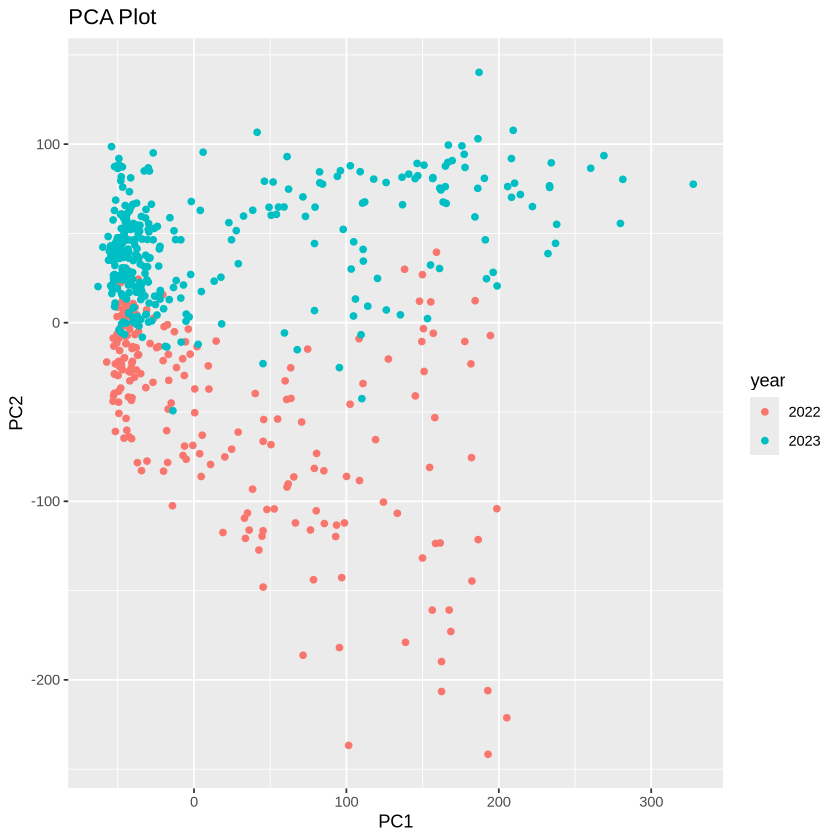

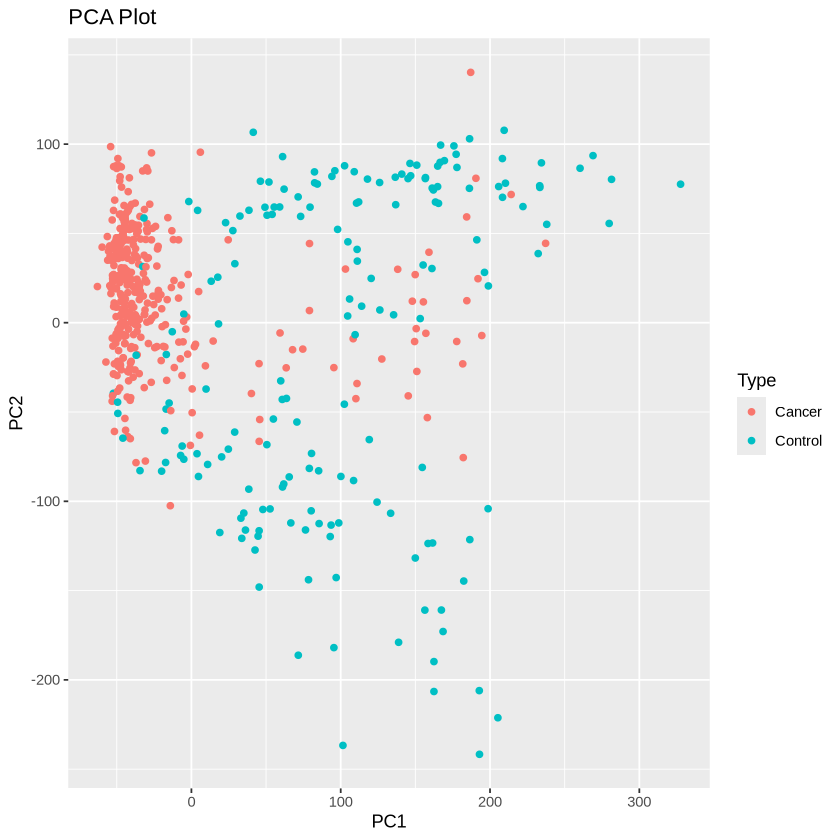

In [ ]:
##------------------- Data batch visulization---------------------------------
pca_result <- prcomp(t(cpm), scale = TRUE)

# Extract the principal components
pca_data <- as.data.frame(pca_result$x)

# Merge the PCA data with sample information
merged_data <- cbind(pca_data, sample_info)

merged_data_cancer_normal = subset(merged_data, Type == 'Cancer'|Type == 'Control')

# Create a PCA plot with colored dots based on sample types
ggplot(data = merged_data_cancer_normal, aes(x = PC1, y = PC2, color = year)) +
  geom_point() +
  labs(title = "PCA Plot", x = "PC1", y = "PC2")

ggplot(data = merged_data_cancer_normal, aes(x = PC1, y = PC2, color = Type)) +
  geom_point() +
  labs(title = "PCA Plot", x = "PC1", y = "PC2")

asw_cpm = average_silhouette_width_batch(pca_data[, 1:10], sample_info$year, metric = 'cosine')

##### cpm combat

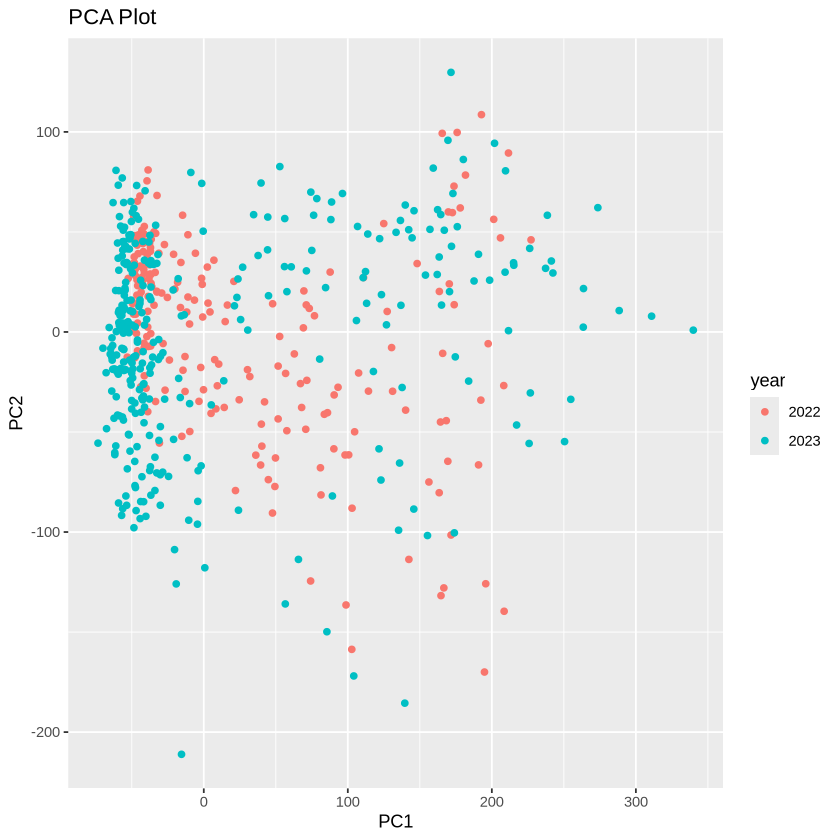

[1] 0.003055091

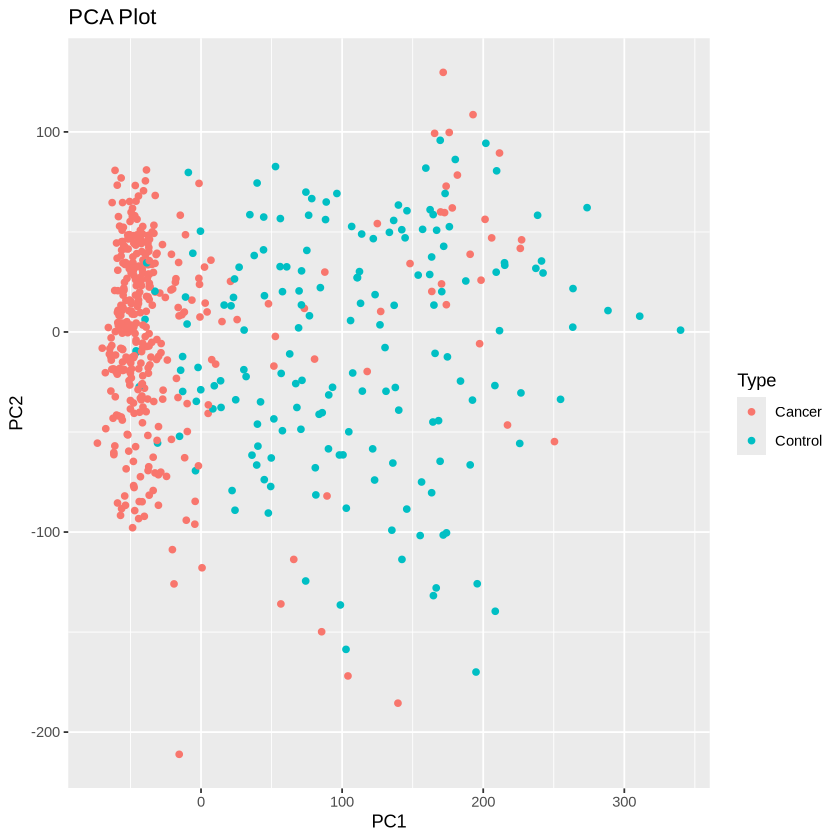

In [ ]:
##------------------- Data batch visulization---------------------------------
cpm_combat = readRDS('/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/cpm_combat.rds')

pca_result <- prcomp(t(cpm_combat), scale = TRUE)

# Extract the principal components
pca_data <- as.data.frame(pca_result$x)

# Merge the PCA data with sample information
merged_data <- cbind(pca_data, sample_info)

merged_data_cancer_normal = subset(merged_data, Type == 'Cancer'|Type == 'Control')

# Create a PCA plot with colored dots based on sample types
ggplot(data = merged_data_cancer_normal, aes(x = PC1, y = PC2, color = year)) +
  geom_point() +
  labs(title = "PCA Plot", x = "PC1", y = "PC2")

ggplot(data = merged_data_cancer_normal, aes(x = PC1, y = PC2, color = Type)) +
  geom_point() +
  labs(title = "PCA Plot", x = "PC1", y = "PC2")

asw_cpm_combat = average_silhouette_width_batch(pca_data[, 1:10], sample_info$year, metric = 'cosine')

asw_cpm_combat

##### irp

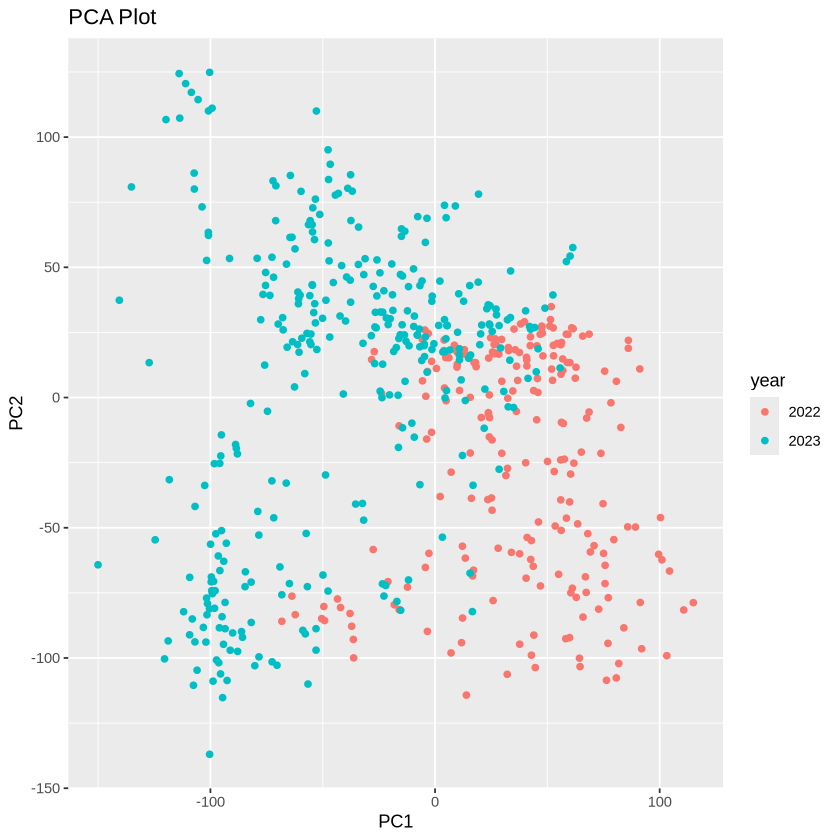

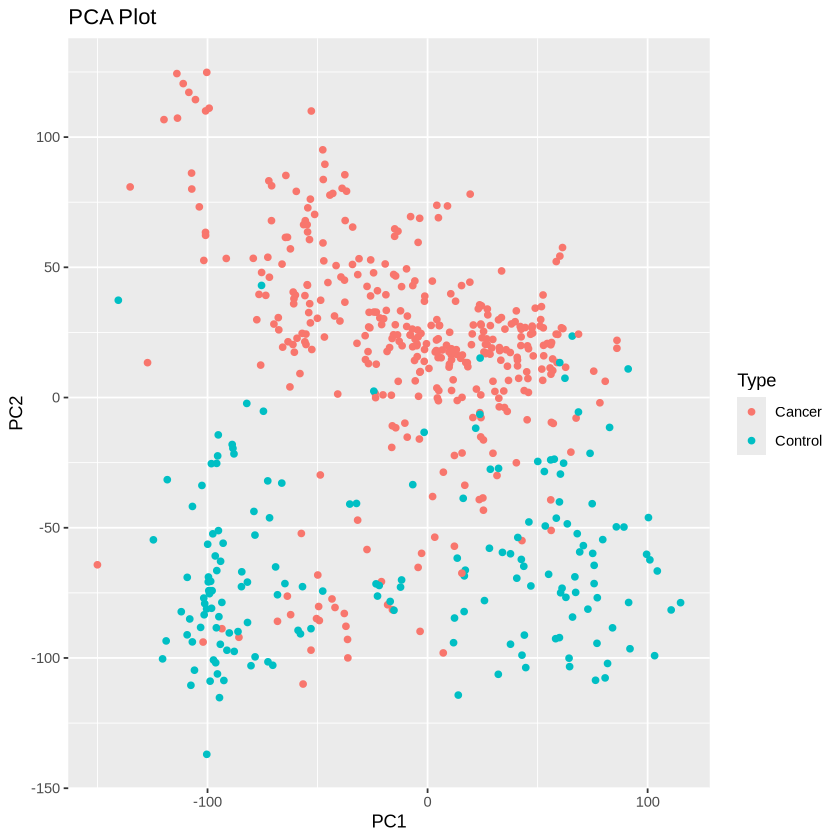

In [22]:
##------------------- Data batch visulization---------------------------------
pca_result <- prcomp(t(irp), scale = TRUE)

# Extract the principal components
pca_data <- as.data.frame(pca_result$x)

# Merge the PCA data with sample information
merged_data <- cbind(pca_data, sample_info)

merged_data_cancer_normal = subset(merged_data, Type == 'Cancer'|Type == 'Control')

# Create a PCA plot with colored dots based on sample types
ggplot(data = merged_data_cancer_normal, aes(x = PC1, y = PC2, color = year)) +
  geom_point() +
  labs(title = "PCA Plot", x = "PC1", y = "PC2")

ggplot(data = merged_data_cancer_normal, aes(x = PC1, y = PC2, color = Type)) +
  geom_point() +
  labs(title = "PCA Plot", x = "PC1", y = "PC2")

asw_irp = average_silhouette_width_batch(pca_data[, 1:10], sample_info$year, metric = 'cosine')

##### irp combat

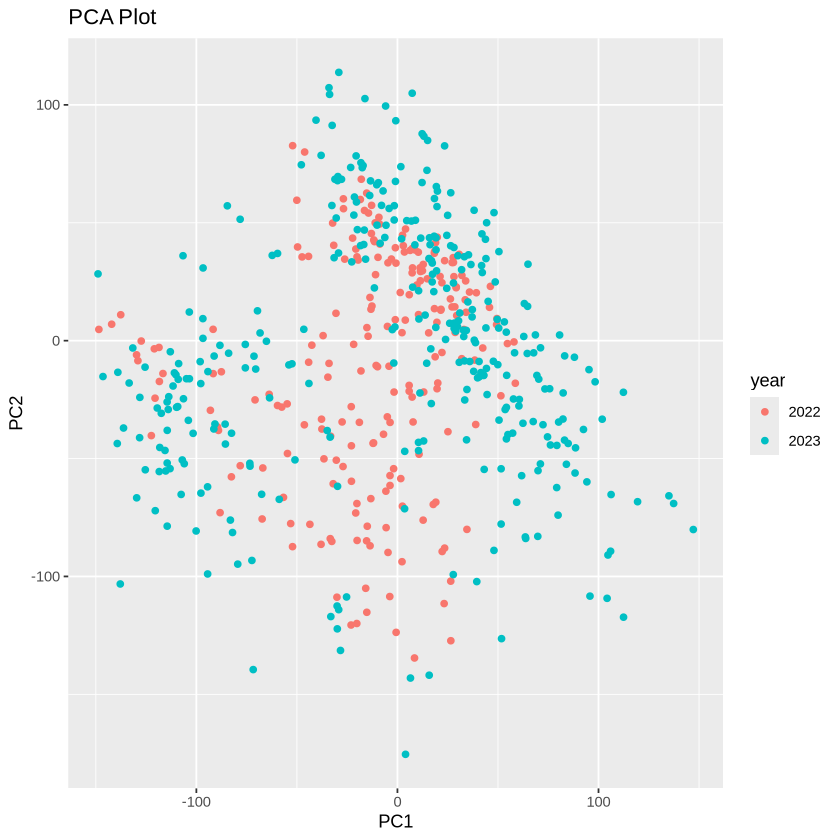

[1] 0.005296389

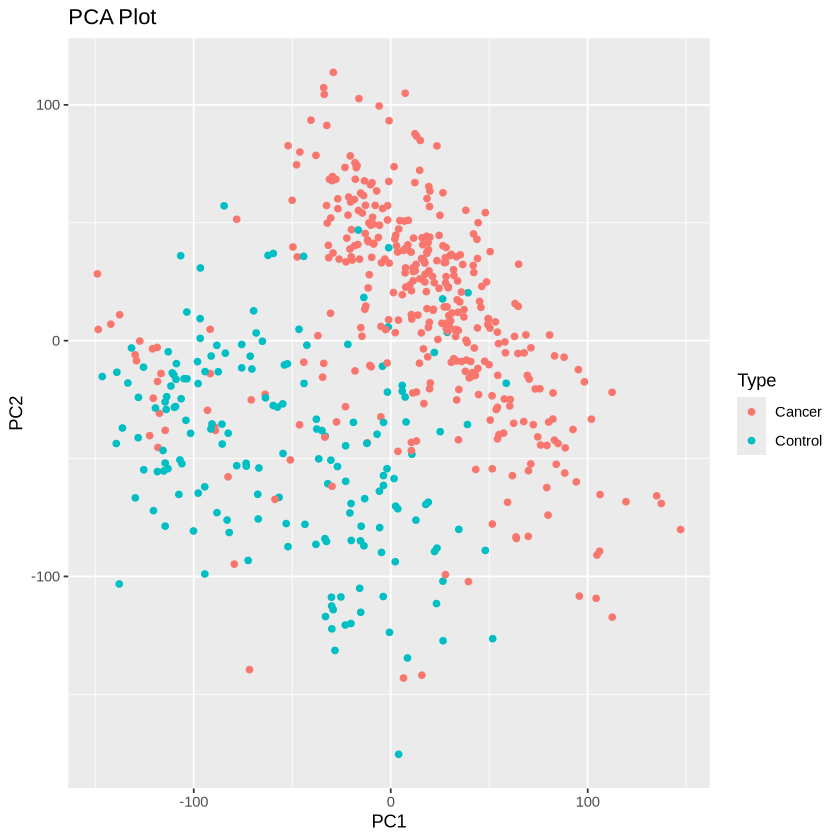

In [15]:
##------------------- Data batch visulization---------------------------------
irp_combat = readRDS('/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/irp_combat.rds')

pca_result <- prcomp(t(irp_combat), scale = TRUE)

# Extract the principal components
pca_data <- as.data.frame(pca_result$x)

# Merge the PCA data with sample information
merged_data <- cbind(pca_data, sample_info)

merged_data_cancer_normal = subset(merged_data, Type == 'Cancer'|Type == 'Control')

# Create a PCA plot with colored dots based on sample types
ggplot(data = merged_data_cancer_normal, aes(x = PC1, y = PC2, color = year)) +
  geom_point() +
  labs(title = "PCA Plot", x = "PC1", y = "PC2")

ggplot(data = merged_data_cancer_normal, aes(x = PC1, y = PC2, color = Type)) +
  geom_point() +
  labs(title = "PCA Plot", x = "PC1", y = "PC2")

asw_irp_combat = average_silhouette_width_batch(pca_data[, 1:10], sample_info$year, metric = 'cosine')

asw_irp_combat

In [16]:
asw_cpm
asw_cpm_combat
asw_irp
asw_irp_combat

[1] 0.3658488

[1] 0.003055091

[1] 0.4217655

[1] 0.005296389

In [ ]:
table(merged_data$year, merged_data$Type)

      
        AA Cancer Control IBD NAA+BL SSA Tis
  2022  80    136      81  41     60   6   2
  2023  92    235      93   0      3   1   3

### chip vs type

`summarise()` has grouped output by 'miRNA测序芯片号'. You can override using
the `.groups` argument.


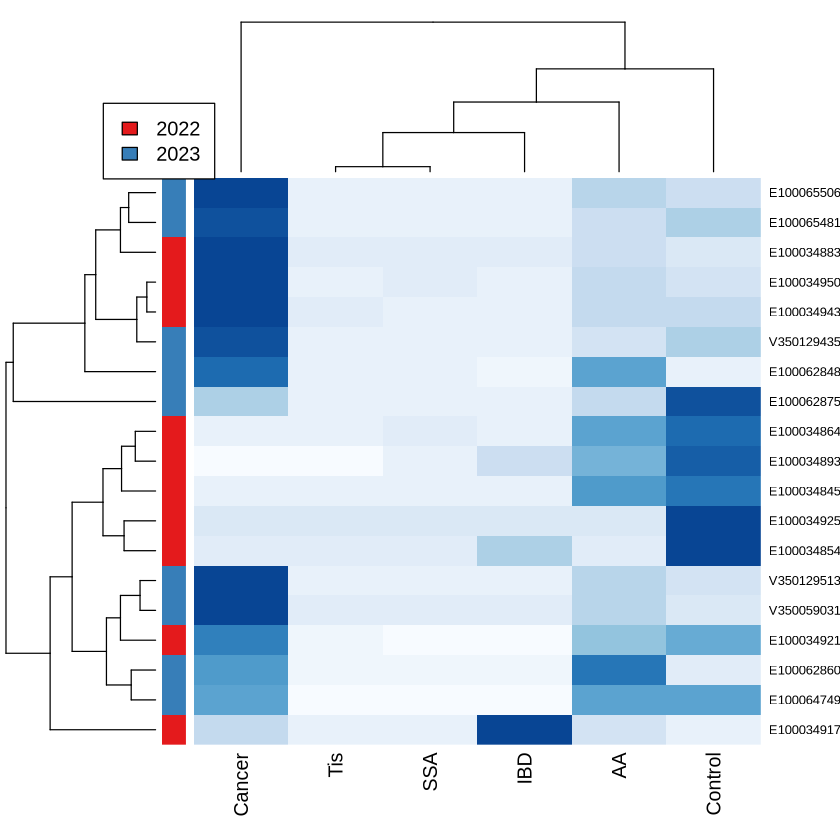

In [14]:
library(RColorBrewer)
sample_info.sub = sample_info[, c('miRNA测序芯片号', 'Type')]
sample_count <- sample_info.sub %>%
  group_by(miRNA测序芯片号, Type) %>%
  summarise(count = n())

sample_count_wide <- spread(sample_count, key = Type, value = count, fill = 0)
sample_count_wide = as.data.frame(sample_count_wide)
rownames(sample_count_wide)= sample_count_wide$`miRNA测序芯片号`
sample_count_wide = sample_count_wide[, -1]

chip_year = unique(sample_info[, c('miRNA测序芯片号', 'year')])
rownames(chip_year) = chip_year$`miRNA测序芯片号`
chip_year = chip_year[rownames(sample_count_wide), ]

my_group <- as.numeric(as.factor(chip_year$year))
colSide <- brewer.pal(9, "Set1")[my_group]
colMain <- colorRampPalette(brewer.pal(8, "Blues"))(25)
heatmap(as.matrix(sample_count_wide), scale = 'row',RowSideColors=colSide, col=colMain)

legend('topleft', legend=unique(chip_year$year), fill=unique(colSide))

### year vs mapping rate

In [56]:
sample_info = readRDS('/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/sample_info.rds')
sample.qc = readxl::read_xlsx("/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/sample qc.xlsx")
sample_info = merge(sample_info, sample.qc, by.x = 'sample', by.y = '样本Lims编号')

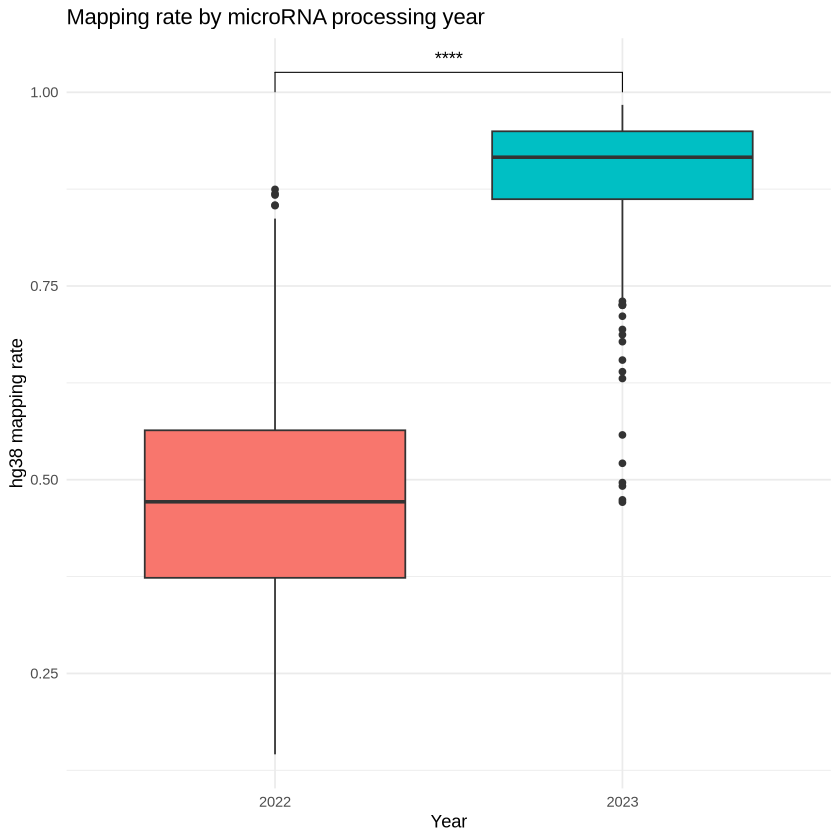

In [60]:
p = ggplot(sample_info, aes(x = year, y = `Genome mapping rate`, fill = year)) +  
geom_boxplot() + 
labs(title = paste("Mapping rate by microRNA processing year"), x = "Year", y = "hg38 mapping rate") +
theme_minimal() 
  
my_comparisons <- list( c("2022","2023"))
p + stat_compare_means(comparisons=my_comparisons,label = "p.signif", method="wilcox.test")+
theme(legend.position = "none")

### storage time and year

In [16]:
table(sample_info$year)


2022 2023 
 406  427 

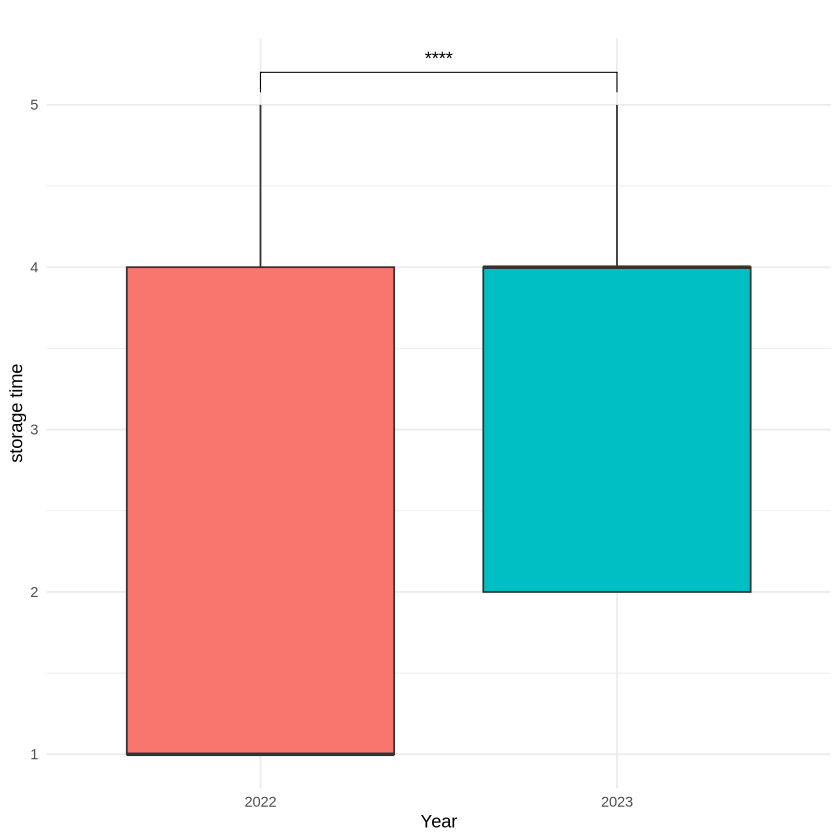

In [17]:
df = sample_info
p = ggplot(df, aes(x = year, y = `storeTime`, fill = year)) +  
geom_boxplot() + 
labs(title = paste(""), x = "Year", y = "storage time") +
theme_minimal() 
  
my_comparisons <- list( c("2022","2023"))
p + stat_compare_means(comparisons=my_comparisons,label = "p.signif", method="wilcox.test")+
theme(legend.position = "none")

### storage time and type

In [18]:
table(sample_info$Type)


     AA  Cancer Control     IBD     SSA     Tis 
    172     371     237      41       7       5 

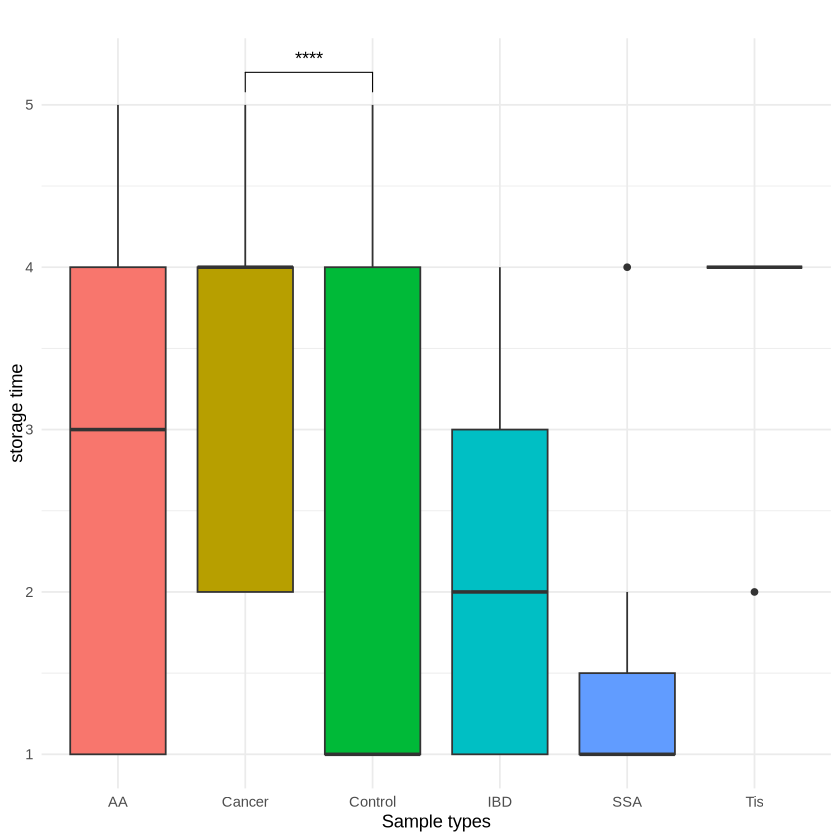

In [19]:
df = sample_info
p = ggplot(df, aes(x = Type, y = `storeTime`, fill = Type)) +  
geom_boxplot() + 
labs(title = paste(""), x = "Sample types", y = "storage time") +
theme_minimal() 
  
my_comparisons <- list( c("Cancer","Control"))
p + stat_compare_means(comparisons=my_comparisons,label = "p.signif", method="wilcox.test")+
theme(legend.position = "none")

# DE

### 2023 DE

In [4]:
sample.info.sub = subset(sample_info, year==2023& (Type=='Cancer'|Type=='Control')) # nolint
sample.info.control = subset(sample_info, Type=='Control') # nolint
sample.info.cancer = subset(sample_info, Type=='Cancer') # nolint

raw_data_HC = raw_data[, sample.info.control$sample]
raw_data_CRC = raw_data[, sample.info.cancer$sample]

keep = rowSums(raw_data_HC>=5)>= 0.8*ncol(raw_data_HC)|rowSums(raw_data_CRC>=5)>= 0.8*ncol(raw_data_CRC)| # nolint
rowSums(raw_data_HC>=15)>= 0.1*ncol(raw_data_HC)|rowSums(raw_data_CRC>=15)>= 0.1*ncol(raw_data_CRC) # nolint

x <- raw_data[keep, sample.info.sub$sample]
group <- sample.info.sub$Type

# Create a DGEList object with the subset of data
y <- DGEList(counts=x, group=group)

# Estimate dispersion
y <- estimateCommonDisp(y)
y <- estimateTagwiseDisp(y)

# Normalize library sizes
y <- calcNormFactors(y)

# Create design matrix
design <- model.matrix(~ group)

# Fit the model
fit <- glmQLFit(y, design)

# Conduct the likelihood ratio test
qlf <- glmQLFTest(fit, coef = 2)

de_result_2023 = qlf$table

saveRDS(de_result_2023, file = 'de_result_2023.rds')

In [18]:
dim(de_result_2023)

[1] 12460     4

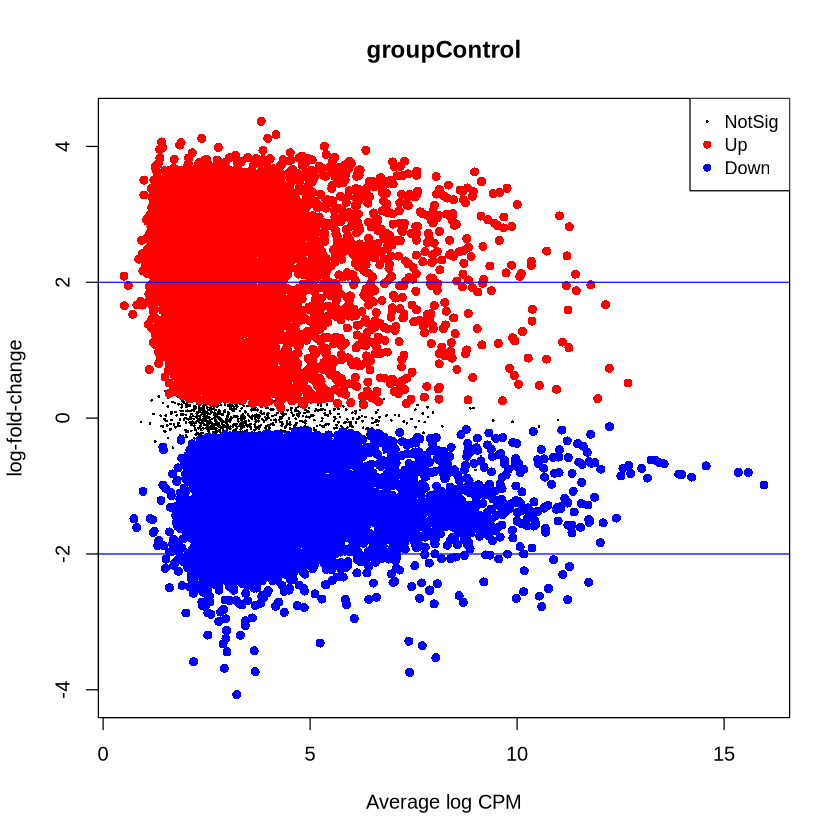

In [8]:
plotMD(qlf)
abline(h=c(-2,2), col="blue")

### 2022 DE

In [5]:
sample.info.sub = subset(sample_info, year==2022& (Type=='Cancer'|Type=='Control')) # nolint
sample.info.control = subset(sample_info, Type=='Control') # nolint
sample.info.cancer = subset(sample_info, Type=='Cancer') # nolint

raw_data_HC = raw_data[, sample.info.control$sample]
raw_data_CRC = raw_data[, sample.info.cancer$sample]
keep = rowSums(raw_data_HC>=5)>= 0.8*ncol(raw_data_HC)|rowSums(raw_data_CRC>=5)>= 0.8*ncol(raw_data_CRC)| # nolint
rowSums(raw_data_HC>=15)>= 0.1*ncol(raw_data_HC)|rowSums(raw_data_CRC>=15)>= 0.1*ncol(raw_data_CRC) # nolint

x <- raw_data[keep, sample.info.sub$sample]
group <- sample.info.sub$Type

# Create a DGEList object with the subset of data
y <- DGEList(counts=x, group=group)

# Estimate dispersion
y <- estimateCommonDisp(y)
y <- estimateTagwiseDisp(y)

# Normalize library sizes
y <- calcNormFactors(y)

# Create design matrix
design <- model.matrix(~ group)

# Fit the model
fit <- glmQLFit(y, design)

# Conduct the likelihood ratio test
qlf <- glmQLFTest(fit, coef = 2)

de_result_2022 = qlf$table

saveRDS(de_result_2022, file = 'de_result_2022.rds')

In [32]:
de_result_2022 = readRDS('de_result_2022.rds')
head(de_result_2022)

,logFC,logCPM,F,PValue
,<dbl>,<dbl>,<dbl>,<dbl>
hsa-miR-451a_delAAAC_insT_0,-2.1688954,11.972356,180.21249,1.672224e-30
hsa-miR-29a-3p_delTAG_0_0,-0.7658128,4.255819,11.05526,1.033978e-03
hsa-miR-451a_delAAA_delT_20GA,-0.9585012,4.465495,43.61869,2.888813e-10
hsa-miR-142-5p_0_insA_17CT,0.7613113,2.992807,12.22282,5.695786e-04
hsa-miR-451a_0_insTA_8TG,-1.5626081,4.054844,73.32835,1.816818e-15
hsa-miR-92a-3p_0_delTGT_0,-0.7706815,5.391561,29.48033,1.472191e-07


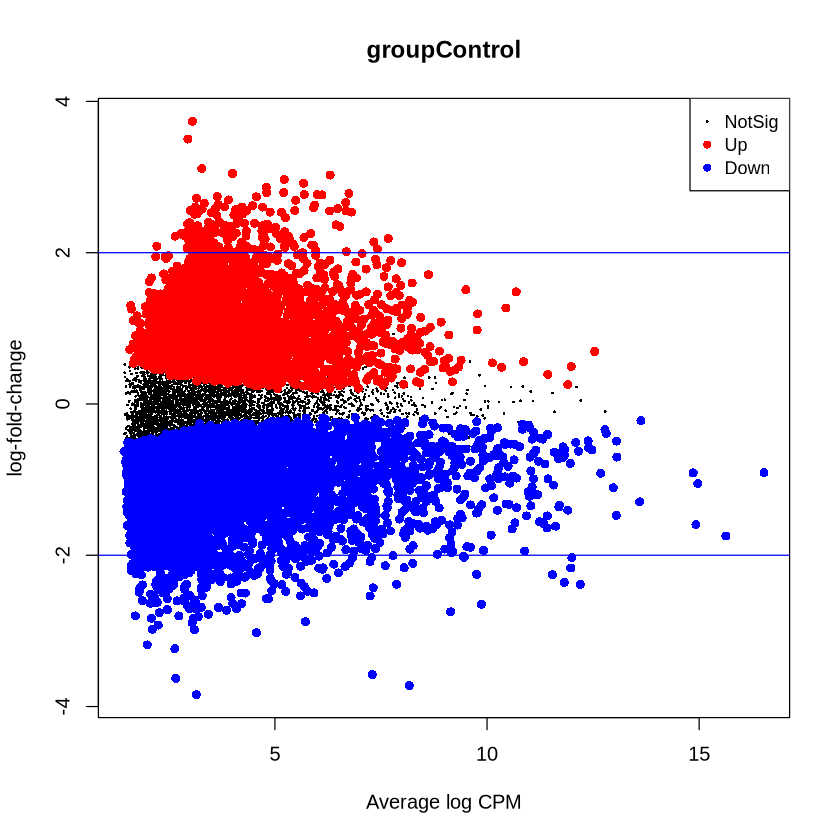

In [139]:
plotMD(qlf)
abline(h=c(-2,2), col="blue")

### Correlation between 2022 and 2023

In [ ]:
de_result_2022 = readRDS('de_result_2022.rds')
de_result_2023 = readRDS('de_result_2023.rds')

de_result_merged = merge(de_result_2022, de_result_2023, by = "row.names", all = FALSE)
correlation = cor.test(de_result_merged$logFC.x, de_result_merged$logFC.y)
plot(de_result_merged$logFC.x, de_result_merged$logFC.y, xlab = '2022 logFC', ylab = '2023 logFC')
abline(lm(de_result_merged$logFC.x ~ de_result_merged$logFC.y), col = "red")
text(-2, 4, labels = paste("Correlation:", round(correlation$estimate, 3)), col = "blue")

### Mixed

In [6]:
sample.info.sub = subset(sample_info, Type=='Cancer'|Type=='Control') # nolint
sample.info.control = subset(sample_info, Type=='Control') # nolint
sample.info.cancer = subset(sample_info, Type=='Cancer') # nolint

raw_data_HC = raw_data[, sample.info.control$sample]
raw_data_CRC = raw_data[, sample.info.cancer$sample]
keep = rowSums(raw_data_HC>=5)>= 0.8*ncol(raw_data_HC)|rowSums(raw_data_CRC>=5)>= 0.8*ncol(raw_data_CRC)| # nolint
rowSums(raw_data_HC>=15)>= 0.1*ncol(raw_data_HC)|rowSums(raw_data_CRC>=15)>= 0.1*ncol(raw_data_CRC) # nolint

x <- raw_data[keep, sample.info.sub$sample]
group <- sample.info.sub$Type

# Create a DGEList object with the subset of data
y <- DGEList(counts=x, group=factor(group, levels = c('Control', 'Cancer')))

# Estimate dispersion
y <- estimateCommonDisp(y)
y <- estimateTagwiseDisp(y)

# Normalize library sizes
y <- calcNormFactors(y)

# Create design matrix
design <- model.matrix(~ group)

# Fit the model
fit <- glmQLFit(y, design)

# Conduct the likelihood ratio test
qlf <- glmQLFTest(fit, coef = 2)

de_result = qlf$table

saveRDS(de_result, file = 'de_result_mixed.rds')

In [66]:
head(de_result)

,logFC,logCPM,F,PValue
,<dbl>,<dbl>,<dbl>,<dbl>
hsa-miR-451a_delAAAC_insT_0,-1.2380521,13.107569,101.94253,4.138420e-22
hsa-miR-29a-3p_delTAG_0_0,0.6186095,4.846136,21.11077,5.376345e-06
hsa-miR-451a_delAAA_delT_20GA,-1.4557965,4.515461,186.24905,9.543636e-37
hsa-miR-142-5p_0_insA_17CT,1.7134005,2.244492,126.11880,1.690338e-26
hsa-miR-451a_0_insTA_8TG,-2.7426219,6.388393,181.37184,6.004063e-36
hsa-miR-92a-3p_0_delTGT_0,-0.7506810,4.811544,49.99849,4.675004e-12


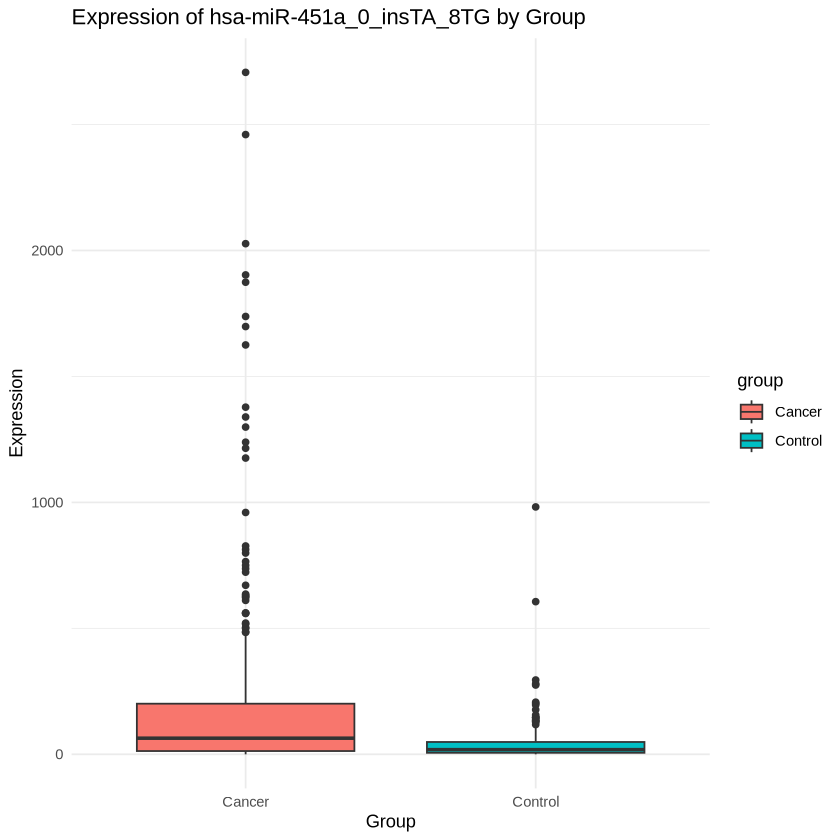

In [64]:
# Assuming you have the count matrix, gene names, and groups available

# Select a specific gene for visualization
selected_gene <- "hsa-miR-451a_0_insTA_8TG"

# Extract expression values for the selected gene
selected_gene_expression <- t(x[selected_gene, ])

# Combine with groups for plotting
data <- data.frame(expression = selected_gene_expression[, 1], group = groups)

# Create a boxplot showing the expression of the selected gene split by group
ggplot(data, aes(x = group, y = expression, fill = group)) +
  geom_boxplot() +
  labs(title = paste("Expression of", selected_gene, "by Group"),
       x = "Group", y = "Expression") +
  theme_minimal()

### Venn

In [23]:
thre = 2

DEgene_22_up = rownames(subset(de_result_2022, logFC>thre&PValue<0.05))
DEgene_22_down = rownames(subset(de_result_2022, -logFC>thre&PValue<0.05))

DEgene_23_up = rownames(subset(de_result_2023, logFC>thre&PValue<0.05))
DEgene_23_down = rownames(subset(de_result_2023, -logFC>thre&PValue<0.05))

DEgene_up = rownames(subset(de_result, logFC>thre&PValue<0.05))
DEgene_down = rownames(subset(de_result, -logFC>thre&PValue<0.05))

length(intersect(DEgene_22_up, DEgene_23_up))/length(unique(c(DEgene_22_up, DEgene_23_up)))
length(intersect(DEgene_22_down, DEgene_23_down))/length(unique(c(DEgene_22_down, DEgene_23_down)))



[1] 0.03463441

[1] 0.02070646

In [149]:
length(DEgene_22_up)
length(DEgene_23_up)
length(DEgene_22_down)
length(DEgene_23_down)

sum(de_result_2023$logFC<(-2))
sum(de_result_2023$logFC>2)

[1] 187

[1] 3577

[1] 300

[1] 538

[1] 538

[1] 3577

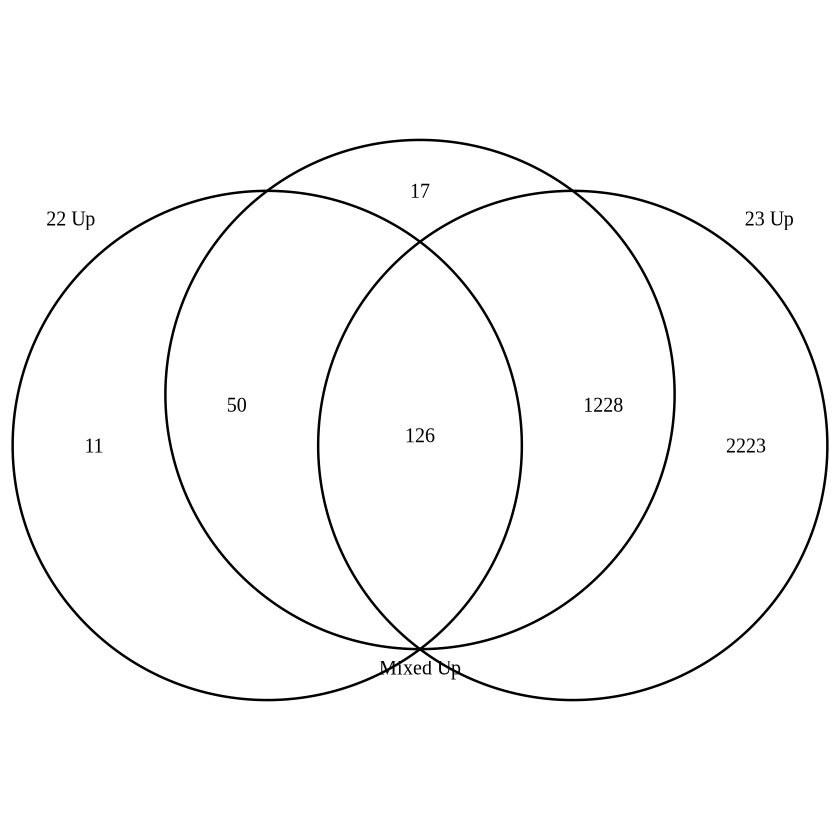

In [25]:
## up
venn_data <- list(vector1 = DEgene_22_up, vector2 = DEgene_23_up, vector3 = DEgene_up)
venn.plot <- venn.diagram(
  x = venn_data,
  category.names = c("22 Up", "23 Up", "Mixed Up"),
  filename = NULL
)
grid.draw(venn.plot)


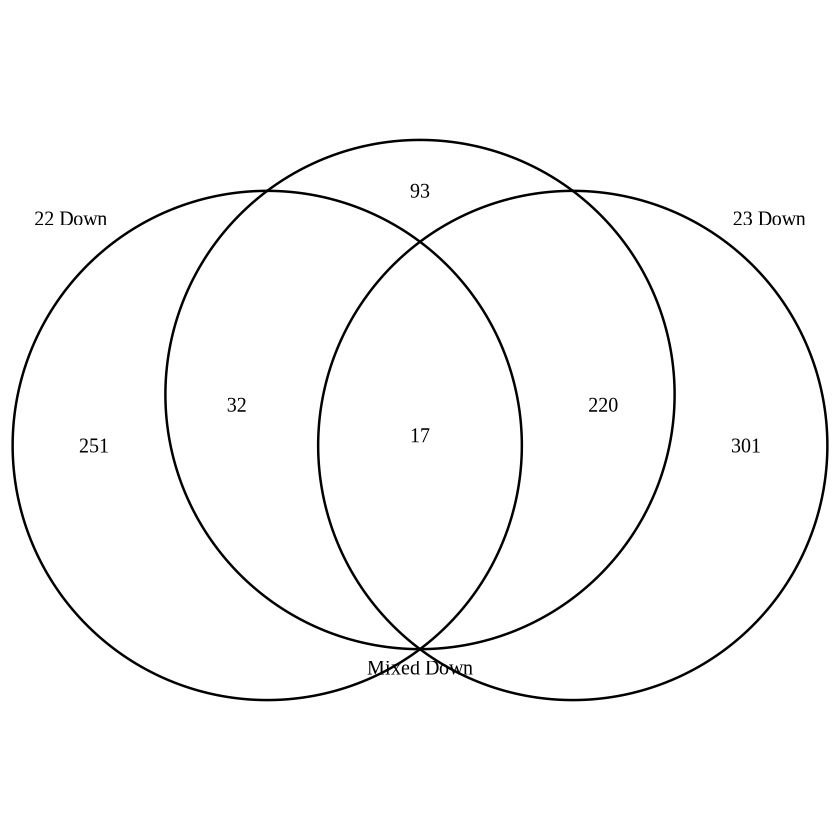

In [26]:
## down
venn_data <- list(vector1 = DEgene_22_down, vector2 = DEgene_23_down, vector3 = DEgene_down)
venn.plot <- venn.diagram(
  x = venn_data,
  category.names = c("22 Down", "23 Down", "Mixed Down"),
  filename = NULL
)
grid.draw(venn.plot)

In [125]:
table(sample_info$year, sample_info$Type)

      
        AA Cancer Control IBD NAA+BL SSA Tis
  2022  80    136      81  41     60   6   2
  2023  92    235      93   0      3   1   3

# Batch correction

#### TMM
- also tried combat-seq, which claimed to be okay for EdgeR input. But it does not work 

In [11]:
sample.info.control = subset(sample_info, Type=='Control') # nolint
sample.info.cancer = subset(sample_info, Type=='Cancer') # nolint
raw_data_HC = raw_data[, sample.info.control$sample]
raw_data_CRC = raw_data[, sample.info.cancer$sample]
keep = rowSums(raw_data_HC>=5)>= 0.8*ncol(raw_data_HC)|rowSums(raw_data_CRC>=5)>= 0.8*ncol(raw_data_CRC)| # nolint
rowSums(raw_data_HC>=15)>= 0.1*ncol(raw_data_HC)|rowSums(raw_data_CRC>=15)>= 0.1*ncol(raw_data_CRC) # nolint

x <- raw_data[keep, ]

# Create a DGEList object with the subset of data
y <- DGEList(counts=x)

# Normalize library sizes
y <- calcNormFactors(y)

tmm <- cpm(y, normalized.lib.sizes = TRUE)

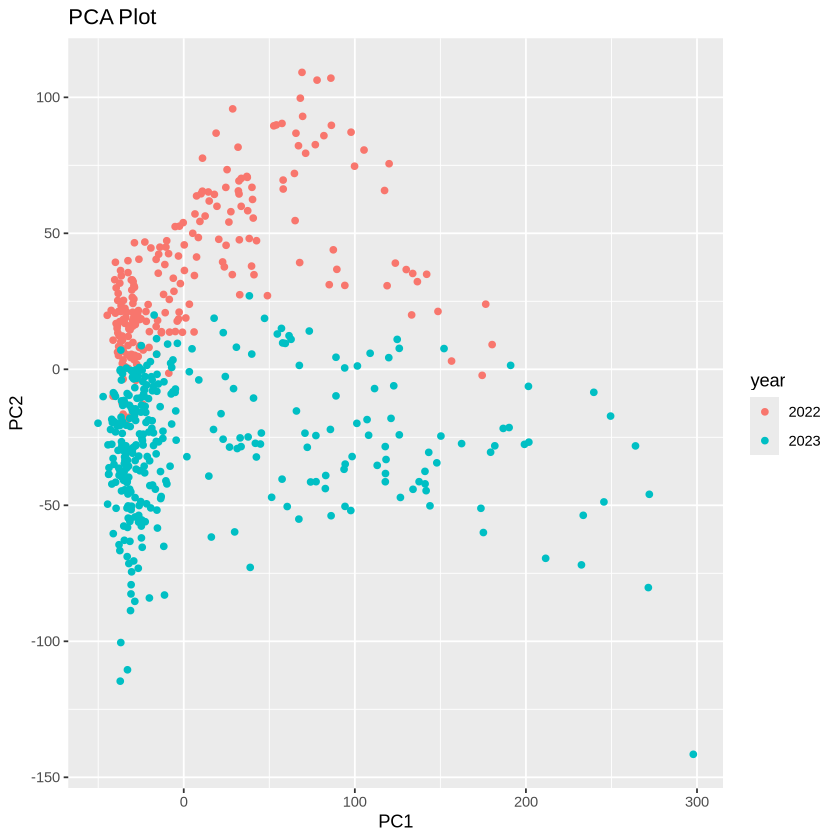

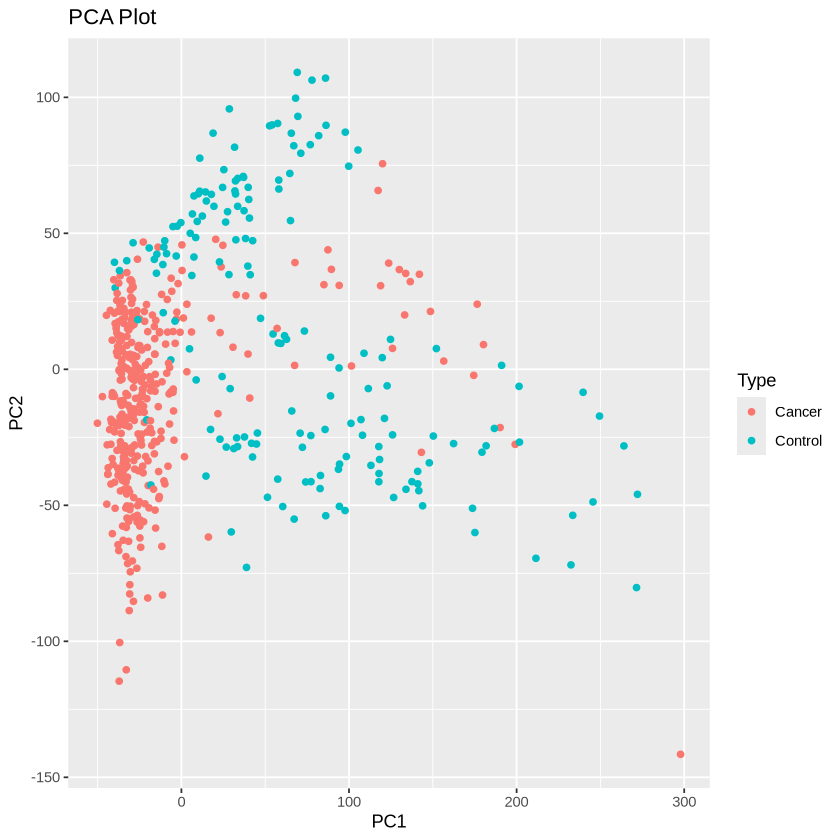

In [14]:
##------------------- Data batch visulization---------------------------------
pca_result <- prcomp(t(tmm), scale = TRUE)

# Extract the principal components
pca_data <- as.data.frame(pca_result$x)

# Merge the PCA data with sample information
merged_data <- cbind(pca_data, sample_info)

merged_data_cancer_normal = subset(merged_data, Type == 'Cancer'|Type == 'Control')

# Create a PCA plot with colored dots based on sample types
ggplot(data = merged_data_cancer_normal, aes(x = PC1, y = PC2, color = year)) +
  geom_point() +
  labs(title = "PCA Plot", x = "PC1", y = "PC2")

ggplot(data = merged_data_cancer_normal, aes(x = PC1, y = PC2, color = Type)) +
  geom_point() +
  labs(title = "PCA Plot", x = "PC1", y = "PC2")

#### ComBat

##### raw data

In [7]:
raw_data = readRDS('/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/raw_data.rds')
x <- raw_data
batch <- factor(sample_info$year)
#design <- model.matrix(~as.factor(Type), data = sample_info)  # Define the design matrix
raw_data_combat <- ComBat(dat = x, batch = batch, mod = NULL, par.prior = TRUE)
saveRDS(raw_data_combat, file = '/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/raw_data_combat.rds')

Found 5 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found2batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




##### cpm

In [8]:
cpm = readRDS('/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/cpm.rds')
sample_info = readRDS('/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/sample_info.rds')
x <- cpm
batch <- factor(sample_info$year)
#design <- model.matrix(~as.factor(Type), data = sample_info)  # Define the design matrix
cpm_combat <- ComBat(dat = x, batch = batch, mod = NULL, par.prior = TRUE)

saveRDS(cpm_combat, file = '/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/cpm_combat.rds')

Found 5 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found2batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




##### irp

In [9]:
irp = readRDS('/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/irp.rds')
sample_info = readRDS('/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/sample_info.rds')
x <- irp
batch <- factor(sample_info$year)
#design <- model.matrix(~as.factor(Type), data = sample_info)  # Define the design matrix
irp_combat <- ComBat(dat = x, batch = batch, mod = NULL, par.prior = TRUE)

saveRDS(irp_combat, file = '/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/irp_combat.rds')

Found 5 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found2batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




# DE after combat

##### raw_data combat DE

In [10]:
raw_data_combat = readRDS('raw_data_combat.rds')
sample_info = readRDS('sample_info.rds')
sum(sample_info$sample == colnames(raw_data_combat))
# Calculate log fold change

sample.info.sub = subset(sample_info, Type=='Cancer'|Type=='Control') # nolint
sample.info.control = subset(sample_info, Type=='Control') # nolint
sample.info.cancer = subset(sample_info, Type=='Cancer') # nolint

raw_data_HC = raw_data_combat[, sample.info.control$sample]
raw_data_CRC = raw_data_combat[, sample.info.cancer$sample]

keep = rowSums(raw_data_HC>=5)>= 0.8*ncol(raw_data_HC)|rowSums(raw_data_CRC>=5)>= 0.8*ncol(raw_data_CRC)| # nolint
rowSums(raw_data_HC>=15)>= 0.1*ncol(raw_data_HC)|rowSums(raw_data_CRC>=15)>= 0.1*ncol(raw_data_CRC) # nolint

feature_kept = rownames(raw_data)[keep]
saveRDS(feature_kept, file = 'feature_kept.rds')


count_matrix = as.matrix(raw_data_combat[keep, sample.info.sub$sample])
groups = sample.info.sub$Type

# Apply the Wilcoxon rank sum test using apply
results <- apply(count_matrix, 1, function(x) {
  wilcox_test <- wilcox.test(x ~ groups)
  logFC <- calculate_logFC(x, groups)
  return(list(p_value = wilcox_test$p.value, logFC = logFC))
})

p_values <- sapply(results, function(res) res$p_value)
logFC_values <- sapply(results, function(res) res$logFC)

# Adjust p-values for multiple testing
p_adj <- p.adjust(p_values, method = "fdr")

de_result_combat = data.frame(pValue = p_values, p.adjust = p_adj, logFC = logFC_values)
rownames(de_result_combat) = rownames(count_matrix)

saveRDS(de_result_combat, file = 'de_result_combat.rds')

[1] 833

##### Direct DE vs Combat DE 
- raw data based
- direct DE was computed using EdgeR
- DE after ComBat was computed using W-rank sum test

In [3]:
getwd()

[1] "/storeData/project/19-preRD_isomir_CRC"

In [ ]:
de_result_combat = readRDS('/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/de_result_combat.rds')
de_result_mixed = readRDS('/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/de_result_mixed.rds')
de_result_2023 = readRDS('/storeData/project/19-preRD_isomir_CRC/code_figures/2_isomiR_marker筛选及对marker的分析/de_result_2023.rds')

thre = 2

DEgene_combat_up = rownames(subset(de_result_combat, logFC>thre&p.adjust<0.05))
DEgene_combat_down = rownames(subset(de_result_combat, -logFC>thre&p.adjust<0.05))

DEgene_23_down = rownames(subset(de_result_2023, logFC>thre&PValue<0.05)) # edgeR reverse the logFC due to unknown code bug
DEgene_23_up = rownames(subset(de_result_2023, -logFC>thre&PValue<0.05))

DEgene_mixed_down = rownames(subset(de_result_mixed, logFC>thre&PValue<0.05))
DEgene_mixed_up = rownames(subset(de_result_mixed, -logFC>thre&PValue<0.05))


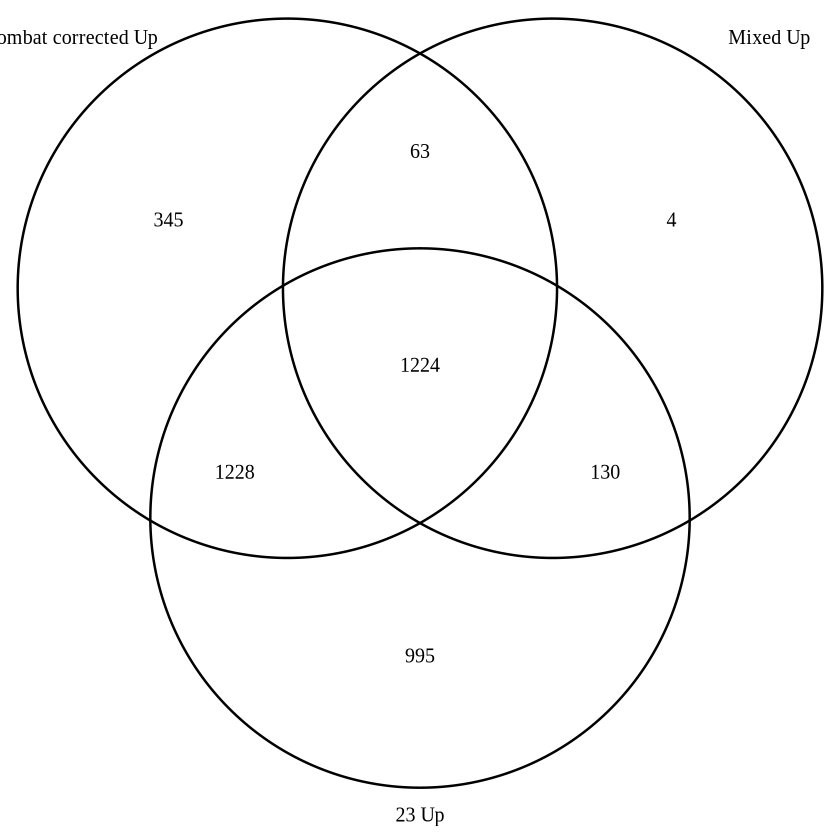

In [5]:
## up
venn_data <- list(vector1 = DEgene_combat_up, vector2 = DEgene_mixed_up, vector3 = DEgene_23_up)
venn.plot <- venn.diagram(
  x = venn_data,
  category.names = c("Combat corrected Up", "Mixed Up", "23 Up"),
  filename = NULL
)
grid.draw(venn.plot)


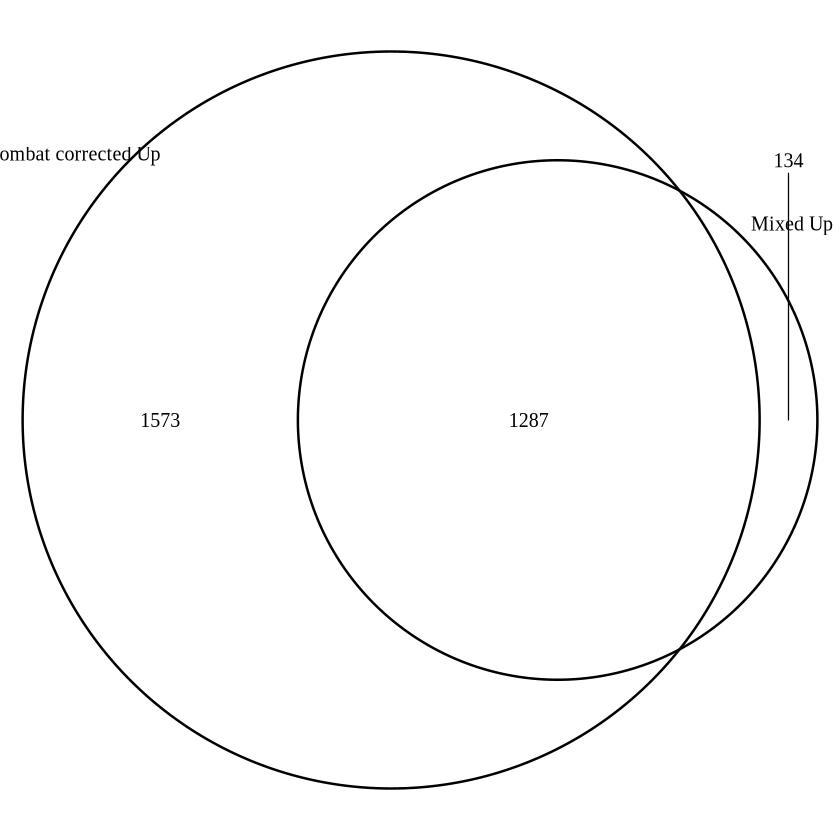

In [6]:
## up
venn_data <- list(vector1 = DEgene_combat_up, vector2 = DEgene_mixed_up)
venn.plot <- venn.diagram(
  x = venn_data,
  category.names = c("Combat corrected Up", "Mixed Up"),
  filename = NULL
)
grid.draw(venn.plot)


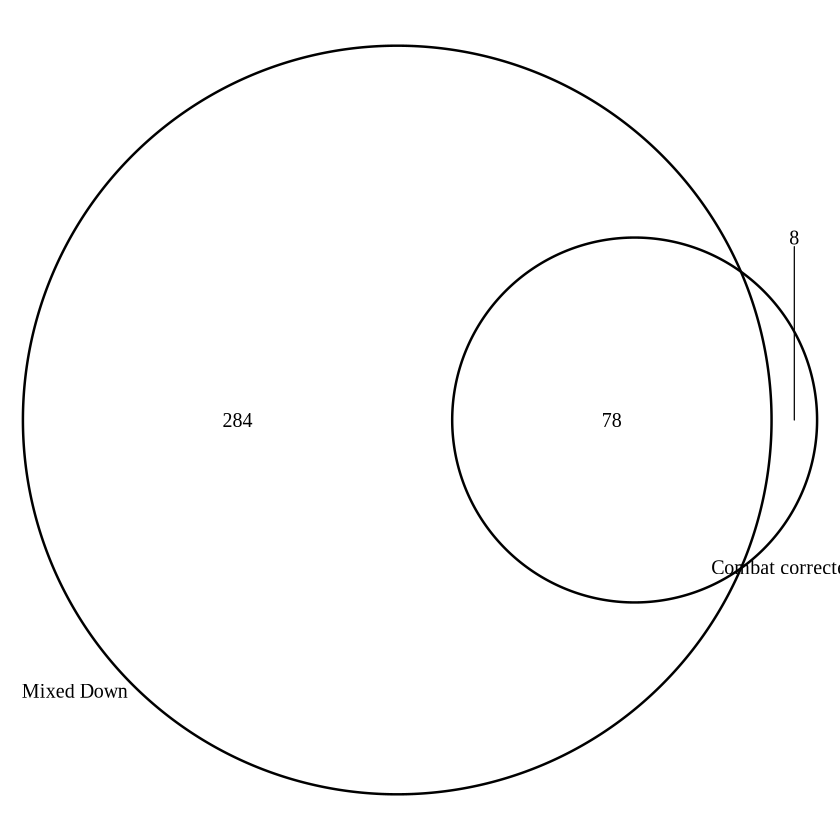

In [7]:
## down
venn_data <- list(vector1 = DEgene_combat_down, vector2 = DEgene_mixed_down)
venn.plot <- venn.diagram(
  x = venn_data,
  category.names = c("Combat corrected Down", "Mixed Down"),
  filename = NULL
)
grid.draw(venn.plot)

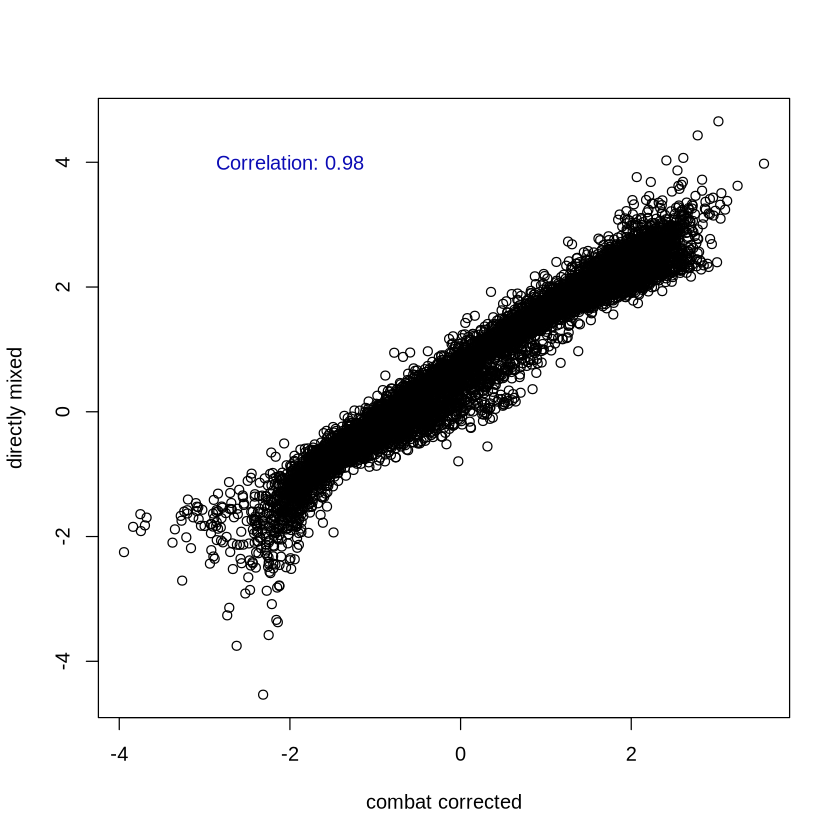

In [13]:
de_result_merged = merge(de_result_mixed, de_result_combat, by = "row.names", all = FALSE)
de_result_merged$logFC.y = -de_result_merged$logFC.y

correlation = cor.test(de_result_merged$logFC.x, de_result_merged$logFC.y)
plot(de_result_merged$logFC.x, de_result_merged$logFC.y, xlab = 'combat corrected', ylab = 'directly mixed')
#abline(lm(de_result_merged$logFC.x ~ de_result_merged$logFC.y), col = "red")
text(-2, 4, labels = paste("Correlation:", round(correlation$estimate, 3)), col = "#0c0cb5")

##### irp combat DE

In [11]:
irp_combat = readRDS('irp_combat.rds')

count_matrix = as.matrix(irp_combat[feature_kept, sample.info.sub$sample])

groups = sample.info.sub$Type

# Apply the Wilcoxon rank sum test using apply
results <- apply(count_matrix, 1, function(x) {
  wilcox_test <- wilcox.test(x ~ groups)
  logFC <- calculate_logFC(x, groups)
  return(list(p_value = wilcox_test$p.value, logFC = logFC))
})

p_values <- sapply(results, function(res) res$p_value)
logFC_values <- sapply(results, function(res) res$logFC)

# Adjust p-values for multiple testing
p_adj <- p.adjust(p_values, method = "fdr")

de_result_combat_irp = data.frame(pValue = p_values, p.adjust = p_adj, logFC = logFC_values)
rownames(de_result_combat_irp) = rownames(count_matrix)

saveRDS(de_result_combat_irp, file = 'de_result_combat_irp.rds')

In [40]:
de_result_combat_irp[1:5, ]

,pValue,p.adjust,logFC
,<dbl>,<dbl>,<dbl>
hsa-let-7a-3p_0_0_0,4.032716e-02,4.988716e-02,0.08948816
hsa-let-7a-3p_0_0_21CT,1.147261e-13,3.009162e-13,0.61543119
hsa-let-7a-3p_0_delC_0,2.853591e-33,2.528696e-32,0.42875446
hsa-let-7a-3p_0_delTC_0,1.152459e-08,2.291907e-08,0.52632807
hsa-let-7a-3p_0_insC_0,8.070779e-29,5.057600e-28,-1.84030936


##### CPM combat DE

In [12]:
cpm_combat = readRDS('cpm_combat.rds')
sample_info = readRDS('sample_info.rds')
sum(sample_info$sample == colnames(cpm_combat))

count_matrix = as.matrix(irp_combat[feature_kept, sample.info.sub$sample])

groups = sample.info.sub$Type

# Apply the Wilcoxon rank sum test using apply
results <- apply(count_matrix, 1, function(x) {
  wilcox_test <- wilcox.test(x ~ groups)
  logFC <- calculate_logFC(x, groups)
  return(list(p_value = wilcox_test$p.value, logFC = logFC))
})

p_values <- sapply(results, function(res) res$p_value)
logFC_values <- sapply(results, function(res) res$logFC)

# Adjust p-values for multiple testing
p_adj <- p.adjust(p_values, method = "fdr")

de_result_combat_cpm = data.frame(pValue = p_values, p.adjust = p_adj, logFC = logFC_values)
rownames(de_result_combat_cpm) = rownames(count_matrix)

saveRDS(de_result_combat_cpm, file = 'de_result_combat_cpm.rds')

[1] 833